In [65]:
import urllib.request
import zipfile
import pandas as pd
import os
import networkx as nx
import json
import random
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [66]:
# Download the dataset zip file
url = "https://snap.stanford.edu/data/github_stargazers.zip"
filepath = "./../data/github_stargazers.zip"
if not os.path.isfile(filepath):
    urllib.request.urlretrieve(url, filepath)

    # Extract the csv file from the zip file
    with zipfile.ZipFile(filepath, 'r') as zip_ref:
        zip_ref.extractall('./../data/')

In [67]:
# Step 1: Load the graph data and target classes
with open("./../data/github_stargazers/git_edges.json", "r") as f:
    git_edges = json.load(f)
    
git_targets = pd.read_csv("./../data/github_stargazers/git_target.csv", index_col=0)

In [68]:
# Limit the number of graphs to approximately 100 with an equal distribution of all classes
graph_ids = []
for i in range(2):
    class_ids = git_targets[git_targets["target"] == i].index.tolist()
    class_ids = random.sample(class_ids, min(len(class_ids), 100))
    graph_ids.extend(class_ids)

In [69]:
# Filter the graph data and target classes based on the selected graph ids
edges = {graph_id: git_edges[str(graph_id)] for graph_id in graph_ids}
targets = git_targets.loc[graph_ids]

In [70]:
# Step 2: Convert the graph data into a suitable format
nx_graphs = []
for graph_id in graph_ids:
    graph_edges = edges[graph_id]
    G = nx.Graph()
    node_labels = {}
    node_id = 0
    for edge in graph_edges:
        if edge[0] not in node_labels:
            node_labels[edge[0]] = str(node_id)
            node_id += 1
        if edge[1] not in node_labels:
            node_labels[edge[1]] = str(node_id)
            node_id += 1
        G.add_edge(edge[0], edge[1])
    nx.set_node_attributes(G, node_labels, 'label')
    nx_graphs.append(G)

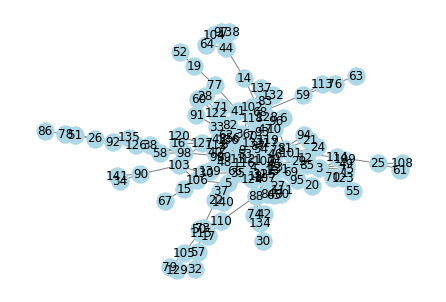

In [71]:
nx.draw(nx_graphs[0], with_labels=True, node_color="lightblue", edge_color="gray")
plt.show()

In [72]:
# Define a function to perform the Weisfeiler-Lehman refinement
def weisfeiler_lehman_refinement(G, node_labels):
    """
    Perform one iteration of the Weisfeiler-Lehman refinement.
    G: NetworkX graph object
    node_labels: dictionary mapping node IDs to labels
    Returns: dictionary mapping node IDs to updated labels
    """
    new_node_labels = {}
    for v in G.nodes():
        neighbors = sorted(list(G.neighbors(v)))
        neighbor_labels = [node_labels[n] for n in neighbors]
        #label = node_labels[v] + "".join(neighbor_labels)
        label = str(node_labels[v]) + "".join(str(label) for label in neighbor_labels)
        new_node_labels[v] = label
    return new_node_labels

In [ ]:
# Define a function to compute the Weisfeiler-Lehman kernel
def weisfeiler_lehman_kernel(G, n_iter):
    """
    Compute the Weisfeiler-Lehman kernel for a NetworkX graph object.
    G: NetworkX graph object
    n_iter: number of iterations to perform the Weisfeiler-Lehman refinement
    Returns: feature vector for the graph
    """
    # Initialize node labels with degree
    node_labels = dict(G.degree())
    for i in range(n_iter):
        node_labels = weisfeiler_lehman_refinement(G, node_labels)
    # Compute a feature vector by counting occurrences of node labels
    feature_vector = [0] * len(set(node_labels.values()))
    for label in node_labels.values():
        #feature_vector[int(label)] += 1
        feature_vector[hash(label) % len(feature_vector)] += 1
    return feature_vector

In [ ]:
def weisfeiler_lehman_kernel_compute(n_iter, nx_graphs):
    # Compute the Weisfeiler-Lehman kernel for each graph in the dataset
    X_wl = []
    max_len = 0
    for G in nx_graphs:
        feature_vector = weisfeiler_lehman_kernel(G, n_iter=n_iter)
        max_len = max(max_len, len(feature_vector))
        X_wl.append(feature_vector)
    for i in range(len(X_wl)):
        padding = [0] * (max_len - len(X_wl[i]))
        X_wl[i] += padding
    return X_wl

In [73]:
X_wl = weisfeiler_lehman_kernel_compute(3, nx_graphs)

In [74]:
# Step 4: Train a machine learning model on the extracted features
X_train, X_test, y_train, y_test = train_test_split(X_wl, targets["target"], test_size=0.3, random_state=94)

In [75]:
# Step 5: Train and Test Model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [76]:
# Step 6: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(f"Classification report: \n{report}")

Accuracy: 0.4666666666666667
Classification report: 
              precision    recall  f1-score   support

           0       0.44      0.54      0.48        28
           1       0.50      0.41      0.45        32

    accuracy                           0.47        60
   macro avg       0.47      0.47      0.47        60
weighted avg       0.47      0.47      0.46        60



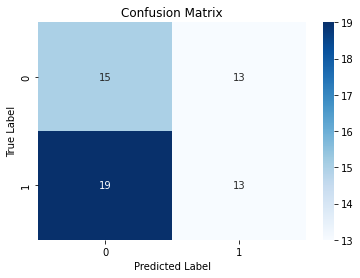

In [77]:
# Visualize classification report using seaborn
cm = confusion_matrix(y_test, y_pred)

# Visualize confusion matrix using seaborn
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()